## Process Files

In [13]:
import re
import pandas as pd
import string
import numpy as np
import nltk
from nltk import pos_tag
from nltk.tag import StanfordNERTagger
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, SparsePCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import GridSearchCV # for Hyper parameter tuning

honk = pd.read_csv("/Users/jojoli/Documents/夏校申请:项目制作/英才计划/正式培养/chinese/datasets/Tang_Dynasty_adj-tagged.csv")
unfeatured = honk.drop(["sentiment_detailed", "dep_nouns", "dep_adjs", "adj_tag"], axis=1)
featured = honk.drop(["sentiment_detailed"], axis=1)
unfeatured.head()

,type,content,clean_content,nostop_clean_content,all_nouns,sentiment
0,偶题阁下厅,静爱青苔院，深宜白鬓翁。貌将松共瘦，心与竹俱空。暖有低檐日，春多飏幕风。平生闲境界，尽在五言中。,静爱青苔院 深宜白鬓翁 貌将松共瘦 心与竹俱空 暖有低檐日 春多飏幕风 平生闲境界 尽在五言中,静爱青苔院 深宜白鬓翁 貌将松共瘦 心竹俱空 暖有低檐日 春多飏幕风 平生闲境界 尽五言中,"['鬓翁', '貌', '心', '竹', '境界', '言']",positive
1,雪中书怀,腊雪一尺厚，云冻寒顽痴。孤城大泽畔，人疏烟火微。愤悱欲谁语，忧愠不能持。天子号仁圣，任贤如事...,腊雪一尺厚 云冻寒顽痴 孤城大泽畔 人疏烟火微 愤悱欲谁语 忧愠不能持 天子号仁圣 任贤如事...,腊雪一尺厚 云冻寒顽痴 孤城大泽畔 人疏烟火微 愤悱欲语 忧愠不能持 天子号仁圣 任贤如事师...,"['云', '泽畔', '人', '烟火', '语', '天子', '号', '事', '师...",positive
2,随驾游青城,因随八马上仙山，顿隔尘埃物象闲。只恐西追王母宴，却忧难得到人间。,因随八马上仙山 顿隔尘埃物象闲 只恐西追王母宴 却忧难得到人间,随八马上仙山 顿隔尘埃物象闲 只恐西追王母宴 却忧难得到人间,"['马上', '仙山', '物象', '宴']",positive
3,冬夜,羁旅复经冬，瓢空盎亦空。泪流寒枕上，迹绝旧山中。凌结浮萍水，雪和衰柳风。曙光鸡未报，嘹唳两三鸿。,羁旅复经冬 瓢空盎亦空 泪流寒枕上 迹绝旧山中 凌结浮萍水 雪和衰柳风 曙光鸡未报 嘹唳两三鸿,羁旅复经冬 瓢空盎亦空 泪流寒枕上 迹绝旧山中 凌结浮萍水 雪衰柳风 曙光鸡未报 嘹唳两三鸿,"['瓢空盎', '泪流', '枕上', '迹', '山中', '水', '雪', '风', ...",negative
4,酬白乐天杏花园,刘郎不用闲惆怅，且作花间共醉人。算得贞元旧朝士，几人同见太和春。,刘郎不用闲惆怅 且作花间共醉人 算得贞元旧朝士 几人同见太和春,刘郎不用闲惆怅 作花间共醉人 算得贞元旧朝士 几人见太春,"['花间', '人']",positive


## Feature extraction

In [2]:
# Initiation

from jiayan import load_lm
from jiayan import CharHMMTokenizer
from jiayan import CRFPOSTagger
from jiayan import CRFSentencizer

lm = load_lm('/Users/jojoli/jiayan_models/jiayan.klm')
postagger = CRFPOSTagger()
postagger.load('/Users/jojoli/jiayan_models/pos_model')

In [3]:
def count_words(text):
    cnt = len(str(text))
    for ch in str(text):
        if ch == " ":
            cnt-=1
    return cnt

def count_stopwords(text):
    cnt = 0
    ls = postagger.postag(text)
    for chr in ls:
        if chr == 'p' or chr == 'r' or chr == 'u' or chr == 'c':
            cnt+=1
    return cnt

def count_lines(text):
    return len(str(text).split())

def count_tag_noun(text):
    pos_counts = 0
    ls = postagger.postag(text)
    for each in ls:
        if each == 'b' or each == 'n' or each == 'nd' or each == 'nh' or each == 'ni' or each == 'nl' or each == 'ns' or each == 'nt' or each == 'nz' or each == 'j':
            pos_counts+=1
    return pos_counts

def count_tag_pron(text):
    pos_counts = 0
    ls = postagger.postag(text)
    for each in ls:
        if each == 'r':
            pos_counts+=1
    return pos_counts

def count_tag_verb(text):
    pos_counts = 0
    ls = postagger.postag(text)
    for each in ls:
        if each == 'v':
            pos_counts+=1
    return pos_counts

def count_tag_adj(text):
    pos_counts = 0
    ls = postagger.postag(text)
    for each in ls:
        if each == 'a' or each == 'z':
            pos_counts+=1
    return pos_counts

def count_tag_adv(text):
    pos_counts = 0
    ls = postagger.postag(text)
    for each in ls:
        if each == 'd':
            pos_counts+=1
    return pos_counts

def count_num_positive_imagery(text):
    cnt = 0
    for each in text:
        if each == 'p':
            cnt+=1
    all = count_num_all_imagery(text)
    return cnt / all

def count_num_negative_imagery(text):
    cnt = 0
    for each in text:
        if each == 'n':
            cnt+=1
    all = count_num_all_imagery(text)
    return cnt / all

def count_num_all_imagery(text):
    cnt = 1
    for each in text:
        if (each == ","):
            cnt += 1
    return cnt


# Testing
print(count_tag_verb("砌下落梅如雪乱 拂了一身还满"))
print(count_stopwords("砌下落梅如雪乱 拂了一身还满"))
postagger.postag("砌下落梅如雪乱 拂了一身还满")

5
1


['v', 'nd', 'v', 'n', 'v', 'n', 'd', 'v', 'v', 'u', 'm', 'n', 'd', 'a']

## Train Model Without Feature Engineering

In [4]:
# Using TF-IDF
vectorizer = TfidfVectorizer()
unfeatured_text = vectorizer.fit_transform(unfeatured['clean_content']).toarray()
print(unfeatured_text.shape)

(30, 347)


In [5]:
unfeatured_tfidf = pd.DataFrame(unfeatured_text)
unfeatured_targeted = unfeatured.sentiment
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(unfeatured_tfidf, unfeatured_targeted ,test_size=0.2, random_state=42)

### Random Forest

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
    positive       1.00      0.67      0.80         6

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

--------------The Accuracy of the model----------------------------
Accuracy of Random Forest on test set: 0.66666667


/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.05, 'Confusion_matrix')

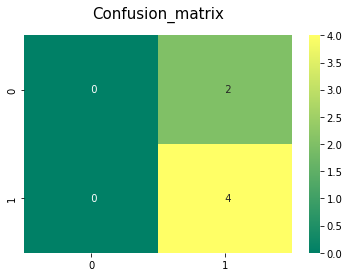

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

umodel1 = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
umodel1.fit(X_train_un, y_train_un)
y_pred_rm1 = umodel1.predict(X_test_un)
print(metrics.classification_report(y_pred_rm1, y_test_un))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of Random Forest on test set: {:.8f}'.format(accuracy_score(y_pred_rm1, y_test_un)))

sns.heatmap(confusion_matrix(y_test_un,y_pred_rm1),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

### Multinomial Naive Bayes

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
    positive       1.00      0.67      0.80         6

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

--------------The Accuracy of the model----------------------------
Accuracy of Multinomial Naive Bayes on test set: 0.66666667


/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.05, 'Confusion_matrix')

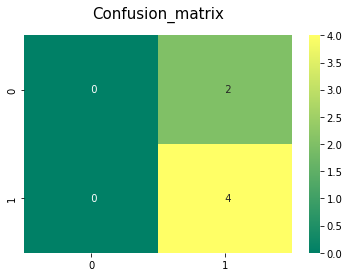

In [7]:
from sklearn.naive_bayes import MultinomialNB

multinomialnb = MultinomialNB()
multinomialnb.fit(X_train_un, y_train_un)
y_pred_rm2 = multinomialnb.predict(X_test_un)
print(metrics.classification_report(y_pred_rm2, y_test_un))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of Multinomial Naive Bayes on test set: {:.8f}'.format(accuracy_score(y_pred_rm2, y_test_un)))

sns.heatmap(confusion_matrix(y_test_un,y_pred_rm2),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

### Support Vector Machine (SVM)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
    positive       1.00      0.67      0.80         6

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

--------------The Accuracy of the model----------------------------
Accuracy of SVM on test set: 0.66666667


/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.05, 'Confusion_matrix')

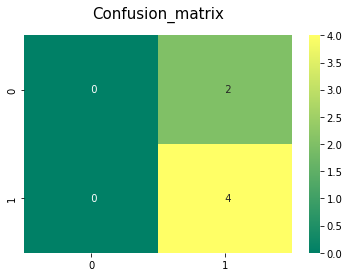

In [8]:
from sklearn.svm import LinearSVC

linearsvc = LinearSVC()

linearsvc.fit(X_train_un, y_train_un)
y_pred_rm3 = linearsvc.predict(X_test_un)
print(metrics.classification_report(y_pred_rm3, y_test_un))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of SVM on test set: {:.8f}'.format(accuracy_score(y_pred_rm3, y_test_un)))

sns.heatmap(confusion_matrix(y_test_un,y_pred_rm3),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

## Train Model With Feature Engineering

In [14]:
featured['word_count'] = featured['clean_content'].apply(lambda x:count_words(x))
featured['stopword_count'] = featured['clean_content'].apply(lambda x:count_stopwords(x))
featured['line_count'] = featured['clean_content'].apply(lambda x:count_lines(x))
featured['stop_vs_words'] = featured['stopword_count']/featured['word_count']
featured['pos_count_noun'] = featured['clean_content'].apply(lambda x:count_tag_noun(x))
featured['pos_count_verb'] = featured['clean_content'].apply(lambda x:count_tag_verb(x))
featured['pos_count_pron'] = featured['clean_content'].apply(lambda x:count_tag_pron(x))
featured['pos_count_adj'] = featured['clean_content'].apply(lambda x:count_tag_adj(x))
featured['pos_count_adv'] = featured['clean_content'].apply(lambda x:count_tag_adv(x))
featured['count_positive'] = featured['adj_tag'].apply(lambda x:count_num_positive_imagery(x))
featured['count_negative'] = featured['adj_tag'].apply(lambda x:count_num_negative_imagery(x))

featured.head(5)

,type,content,clean_content,nostop_clean_content,all_nouns,sentiment,dep_nouns,dep_adjs,adj_tag,word_count,stopword_count,line_count,stop_vs_words,pos_count_noun,pos_count_verb,pos_count_pron,pos_count_adj,pos_count_adv,count_positive,count_negative
0,偶题阁下厅,静爱青苔院，深宜白鬓翁。貌将松共瘦，心与竹俱空。暖有低檐日，春多飏幕风。平生闲境界，尽在五言中。,静爱青苔院 深宜白鬓翁 貌将松共瘦 心与竹俱空 暖有低檐日 春多飏幕风 平生闲境界 尽在五言中,静爱青苔院 深宜白鬓翁 貌将松共瘦 心竹俱空 暖有低檐日 春多飏幕风 平生闲境界 尽五言中,"['鬓翁', '貌', '心', '竹', '境界', '言']",positive,"['青', '苔', '院', '白', '\t']","['靜', '深', '深', '深', '\t']","['positive', 'positive', 'positive', 'positive...",40,3,8,0.075000,22,7,0,11,3,1.000000,0.000000
1,雪中书怀,腊雪一尺厚，云冻寒顽痴。孤城大泽畔，人疏烟火微。愤悱欲谁语，忧愠不能持。天子号仁圣，任贤如事...,腊雪一尺厚 云冻寒顽痴 孤城大泽畔 人疏烟火微 愤悱欲谁语 忧愠不能持 天子号仁圣 任贤如事...,腊雪一尺厚 云冻寒顽痴 孤城大泽畔 人疏烟火微 愤悱欲语 忧愠不能持 天子号仁圣 任贤如事师...,"['云', '泽畔', '人', '烟火', '语', '天子', '号', '事', '师...",positive,"['\t', '亭', '障', '师', '盗', '策', '鞭', '，', '肉',...","['\t', '\t', '牵', '牵', '不', '长', '如', '不', '一'...","['negative', 'negative', 'positive', 'positive...",160,14,32,0.087500,69,71,8,20,10,0.882353,0.117647
2,随驾游青城,因随八马上仙山，顿隔尘埃物象闲。只恐西追王母宴，却忧难得到人间。,因随八马上仙山 顿隔尘埃物象闲 只恐西追王母宴 却忧难得到人间,随八马上仙山 顿隔尘埃物象闲 只恐西追王母宴 却忧难得到人间,"['马上', '仙山', '物象', '宴']",positive,"['馬', '山', '\t']","['因', '，', '\t']","['positive', 'positive']",28,2,4,0.071429,17,6,0,2,3,1.000000,0.000000
3,冬夜,羁旅复经冬，瓢空盎亦空。泪流寒枕上，迹绝旧山中。凌结浮萍水，雪和衰柳风。曙光鸡未报，嘹唳两三鸿。,羁旅复经冬 瓢空盎亦空 泪流寒枕上 迹绝旧山中 凌结浮萍水 雪和衰柳风 曙光鸡未报 嘹唳两三鸿,羁旅复经冬 瓢空盎亦空 泪流寒枕上 迹绝旧山中 凌结浮萍水 雪衰柳风 曙光鸡未报 嘹唳两三鸿,"['瓢空盎', '泪流', '枕上', '迹', '山中', '水', '雪', '风', ...",negative,"['冬', '\t']","['复', '\t']","['negative', 'negative']",40,2,8,0.050000,22,11,0,5,4,0.000000,1.000000
4,酬白乐天杏花园,刘郎不用闲惆怅，且作花间共醉人。算得贞元旧朝士，几人同见太和春。,刘郎不用闲惆怅 且作花间共醉人 算得贞元旧朝士 几人同见太和春,刘郎不用闲惆怅 作花间共醉人 算得贞元旧朝士 几人见太春,"['花间', '人']",positive,"['閑', '\t']","['不', '和']","['positive', 'positive', 'positive']",28,4,4,0.142857,10,7,0,2,5,1.000000,0.000000


In [15]:
# Using TF-IDF
vectorizer2 = TfidfVectorizer()
featured_text = vectorizer2.fit_transform(featured['clean_content']).toarray()
print(featured_text.shape)

(30, 347)


In [16]:
featured_tfidf = pd.DataFrame(featured_text)
featured_targeted = featured.sentiment

features = ['word_count', 'stopword_count', 'line_count',
       'stop_vs_words', 'pos_count_noun', 'pos_count_verb',
       'pos_count_adj', 'pos_count_pron', 'pos_count_adv']
features.append("count_positive")
features.append("count_negative")
featured_all = pd.merge(featured_tfidf,featured[features],left_index=True, right_index=True)
X_train_ref, X_test_ref, y_train_ref, y_test_ref = train_test_split(featured_all, featured_targeted ,test_size=0.2, random_state=50)

### Random Forest

/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         3
    positive       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

--------------The Accuracy of the model----------------------------
Accuracy of Random Forest on test set: 1.00000000


/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Text(0.5, 1.05, 'Confusion_matrix')

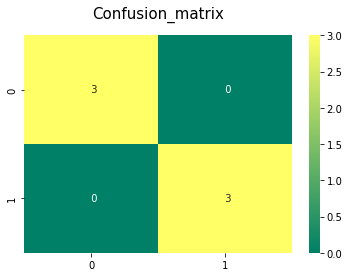

In [17]:
# Random Forest
import seaborn as sns
import matplotlib.pyplot as plt

fmodel1 = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
fmodel1.fit(X_train_ref, y_train_ref)
y_pred_rm4 = fmodel1.predict(X_test_ref)
print(metrics.classification_report(y_pred_rm4, y_test_ref))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of Random Forest on test set: {:.8f}'.format(accuracy_score(y_pred_rm4, y_test_ref)))

sns.heatmap(confusion_matrix(y_test_ref,y_pred_rm4),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)


### Multinomial Naive Bayes

              precision    recall  f1-score   support

    negative       1.00      0.75      0.86         4
    positive       0.67      1.00      0.80         2

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6

--------------The Accuracy of the model----------------------------
Accuracy of Multinomial Naive Bayes on test set: 0.83333333


/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Text(0.5, 1.05, 'Confusion_matrix')

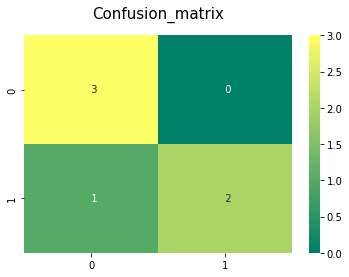

In [18]:
multinomialnb2 = MultinomialNB()
multinomialnb2.fit(X_train_ref, y_train_ref)
y_pred_rm5 = multinomialnb2.predict(X_test_ref)
print(metrics.classification_report(y_pred_rm5, y_test_ref))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of Multinomial Naive Bayes on test set: {:.8f}'.format(accuracy_score(y_pred_rm5, y_test_ref)))

sns.heatmap(confusion_matrix(y_test_ref,y_pred_rm5),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

### Support Vector Machine (SVM)

              precision    recall  f1-score   support

    negative       0.67      1.00      0.80         2
    positive       1.00      0.75      0.86         4

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6

--------------The Accuracy of the model----------------------------
Accuracy of SVM on test set: 0.83333333


/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jojoli/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Text(0.5, 1.05, 'Confusion_matrix')

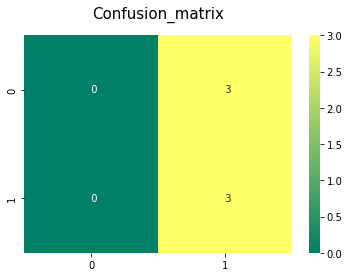

In [19]:
linearsvc = LinearSVC()

linearsvc.fit(X_train_ref, y_train_ref)
y_pred_rm6 = linearsvc.predict(X_test_ref)
print(metrics.classification_report(y_pred_rm6, y_test_ref))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of SVM on test set: {:.8f}'.format(accuracy_score(y_pred_rm6, y_test_ref)))

sns.heatmap(confusion_matrix(y_test_ref,y_pred_rm2),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

In [ ]:
featured.to_csv("/Users/jojoli/Documents/夏校申请:项目制作/英才计划/正式培养/chinese/datasets/Tang_Dynasty_featured.csv")

## Coreference Resolution + Feature Engineering

In [ ]:
# 是否可以在coreference resolution的基础上进行feature engineering
# Add the number of positive and negative imageries according to the results in
    # coreference resolution to feature engineering and then train with the same models
# 存储标注：https://blog.csdn.net/Itsme_MrJJ/article/details/123830831

In [ ]:
import functions
# Use the last function of en_functions.py and read the csv file
# Train model